In [70]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import Pipeline
%config InlineBackend.figure_format = 'svg'
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')
import random
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV
from yellowbrick.regressor import prediction_error
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix , precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold


In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
df = pd.read_csv('/content/mkhdata.csv')

In [73]:
df

,Unnamed: 0,city,date,time,year,month,day,hour,minute,weather,temp,wind,humidity,barometer,visibility
0,94805,Mecca,2017-01-01,00:00,2017,1,1,24,0,Clear,22,7,69.0,1016.0,16
1,94806,Mecca,2017-01-01,01:00,2017,1,1,1,0,Clear,21,0,73.0,1015.0,16
2,94807,Mecca,2017-01-01,02:00,2017,1,1,2,0,Clear,21,7,73.0,1015.0,16
3,94808,Mecca,2017-01-01,03:00,2017,1,1,3,0,Clear,21,7,73.0,1015.0,16
4,94809,Mecca,2017-01-01,04:00,2017,1,1,4,0,Clear,21,7,73.0,1015.0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20263,115068,Mecca,2019-04-30,19:00,2019,4,30,19,0,Clear,32,15,43.0,1009.0,16
20264,115069,Mecca,2019-04-30,20:00,2019,4,30,20,0,Clear,31,15,46.0,1009.0,16
20265,115070,Mecca,2019-04-30,21:00,2019,4,30,21,0,Clear,30,19,49.0,1010.0,16
20266,115071,Mecca,2019-04-30,22:00,2019,4,30,22,0,Clear,30,15,49.0,1010.0,16


In [74]:
df.shape

(20268, 15)

In [75]:
df.describe()

,Unnamed: 0,year,month,day,hour,minute,temp,wind,humidity,barometer,visibility
count,20268.000000,20268.000000,20268.000000,20268.000000,20268.000000,20268.000000,20268.000000,20268.000000,20268.000000,20268.000000,20268.000000
mean,104938.500000,2017.710480,5.958309,15.681419,12.498076,0.049142,29.023239,13.913312,54.158772,1008.713919,10.711417
std,5851.011964,0.698316,3.511464,8.787419,6.919406,1.198201,4.607044,8.369067,15.479241,4.854478,7.460926
min,94805.000000,2017.000000,1.000000,1.000000,1.000000,0.000000,16.000000,-1.000000,5.000000,996.000000,-1.000000
25%,99871.750000,2017.000000,3.000000,8.000000,7.000000,0.000000,26.000000,7.000000,44.000000,1005.000000,-1.000000
50%,104938.500000,2018.000000,6.000000,16.000000,12.000000,0.000000,29.000000,13.000000,55.000000,1009.000000,16.000000
75%,110005.250000,2018.000000,9.000000,23.000000,18.000000,0.000000,32.000000,19.000000,66.000000,1013.000000,16.000000
max,115072.000000,2019.000000,12.000000,31.000000,24.000000,59.000000,49.000000,163.000000,100.000000,1021.000000,16.000000


In [76]:
df.dtypes

Unnamed: 0      int64
city           object
date           object
time           object
year            int64
month           int64
day             int64
hour            int64
minute          int64
weather        object
temp            int64
wind            int64
humidity      float64
barometer     float64
visibility      int64
dtype: object

EDA

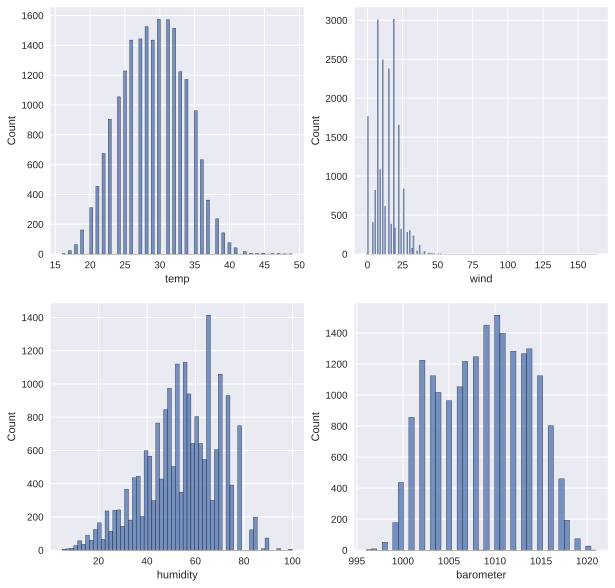

In [77]:
cols_to_plot = ['temp', 'wind', 'humidity', 'barometer']
plt.figure(figsize=(10, 10))
for i, col in enumerate(cols_to_plot):
    plt.subplot(2, 2, i+1)
    sns.histplot(data=df, x=col)

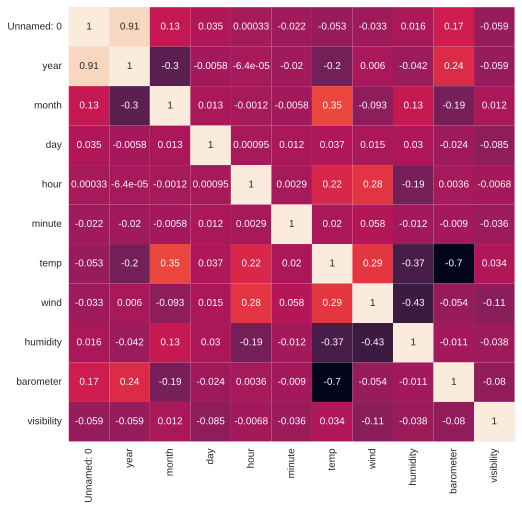

In [78]:
#Plot the correlation heatmap
corr_matrix = df.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr_matrix, annot=True, cbar=False)
plt.show()

In [79]:
df = pd.get_dummies(df)

In [80]:
df

,Unnamed: 0,year,month,day,hour,minute,temp,wind,humidity,barometer,visibility,city_Mecca,date_2017-01-01,date_2017-01-02,date_2017-01-03,date_2017-01-04,date_2017-01-05,date_2017-01-06,date_2017-01-07,date_2017-01-08,date_2017-01-09,date_2017-01-10,date_2017-01-11,date_2017-01-12,date_2017-01-13,date_2017-01-14,date_2017-01-15,date_2017-01-16,date_2017-01-17,date_2017-01-18,date_2017-01-19,date_2017-01-20,date_2017-01-21,date_2017-01-22,date_2017-01-23,date_2017-01-24,date_2017-01-25,date_2017-01-26,date_2017-01-27,date_2017-01-28,...,time_23:00,time_23:30,weather_Broken Clouds,weather_Clear,weather_Dense Fog,weather_Drizzle Broken Clouds,weather_Duststorm,weather_Extremely Hot,weather_Fog,weather_Haze,weather_Hot,weather_Light Rain Broken Clouds,weather_Light Rain Mostly Cloudy,weather_Light Rain Partly Sunny,weather_Light Rain Passing Clouds,weather_Low Level Haze,weather_Mild,weather_More Clouds Than Sun,weather_Overcast,weather_Partly Cloudy,weather_Partly Sunny,weather_Passing Clouds,weather_Rain Broken Clouds,weather_Rain Partly Sunny,weather_Rain Passing Clouds,weather_Rain Scattered Clouds,weather_Sandstorm,weather_Scattered Clouds,weather_Smoke,weather_Sunny,weather_Thundershowers Partly Sunny,weather_Thundershowers Passing Clouds,weather_Thundershowers Scattered Clouds,weather_Thunderstorms Broken Clouds,weather_Thunderstorms Overcast,weather_Thunderstorms Partly Cloudy,weather_Thunderstorms Partly Sunny,weather_Thunderstorms Passing Clouds,weather_Thunderstorms Scattered Clouds,weather_Warm
0,94805,2017,1,1,24,0,22,7,69.0,1016.0,16,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,94806,2017,1,1,1,0,21,0,73.0,1015.0,16,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,94807,2017,1,1,2,0,21,7,73.0,1015.0,16,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,94808,2017,1,1,3,0,21,7,73.0,1015.0,16,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,94809,2017,1,1,4,0,21,7,73.0,1015.0,16,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20263,115068,2019,4,30,19,0,32,15,43.0,1009.0,16,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20264,115069,2019,4,30,20,0,31,15,46.0,1009.0,16,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20265,115070,2019,4,30,21,0,30,19,49.0,1010.0,16,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20266,115071,2019,4,30,22,0,30,15,49.0,1010.0,16,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [81]:
# import chart_studio.plotly as py
import cufflinks as cf
import plotly.express as px


In [82]:
#plt.figure(figsize=(16,8))
#sns.lineplot(data=df)

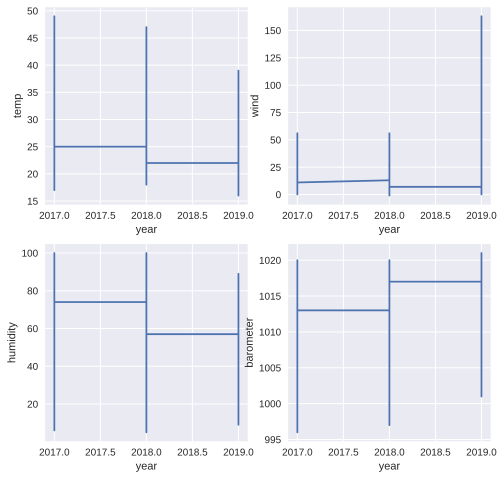

In [83]:
figure, ax = plt.subplots(2, 2, figsize=(8,8))
plt.style.use('seaborn')

ax1 = ax[0]
ax2 = ax[1]

# Plot the Number of Page Loads with time
ax1[0].plot(df['year'], df['temp'])
ax1[0].set_xlabel("year")
ax1[0].set_ylabel("temp")

# Plot the Number of Unique Visits with time
ax1[1].plot(df['year'], df['wind'])
ax1[1].set_xlabel("year")
ax1[1].set_ylabel("wind")

# Plot the Number of First Time visits with time
ax2[0].plot(df['year'], df['humidity'])
ax2[0].set_xlabel("year")
ax2[0].set_ylabel("humidity")

# Plot the Number of Returning visits with time
ax2[1].plot(df['year'], df['barometer'])
ax2[1].set_xlabel("year")
ax2[1].set_ylabel("barometer")

figure.show()

In [84]:
df_Train, df_test = train_test_split(df, test_size=0.2, random_state= 30)

df_train, df_val = train_test_split(df_Train, test_size=0.2, random_state= 30)

In [85]:
scaler = StandardScaler()

df_train_scaled =scaler.fit_transform(df_train.values)
df_val_scaled = scaler.transform(df_val.values)
df_test_scaled = scaler.transform(df_test.values)

In [86]:
print(f'Shape of train:', df_train.shape)
print(f'Shape of validation:', df_val.shape)
print(f'Shape of test:', df_test.shape)

Shape of train: (12971, 963)
Shape of validation: (3243, 963)
Shape of test: (4054, 963)


In [87]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout ,BatchNormalization
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow.keras.callbacks import EarlyStopping

In [88]:
# # Build the LSTM Stack model
#model=Sequential()
# Adding first LSTM layer
#model.add(LSTM(150,return_sequences=True,input_shape=(100,1)))
#model.add(Dropout(0.2)) # Dropout regularisation
# second LSTM layer 
#model.add(LSTM(150,return_sequences=True))
# Adding third LSTM layer 
#model.add(LSTM(150, return_sequences=True))
#model.add(Dropout(0.2))
# Adding fourth LSTM layer
#model.add(LSTM(150))
#model.add(Dropout(0.2))
# Adding the Output Layer
#model.add(Dense(1))
#model.compile(loss='mean_squared_error',optimizer='adam')

In [89]:
#model.summary()

In [90]:
#df_train.drop('weather',axis =1,inplace=True)

### LinearRegression model

In [91]:
X_train = df_train.drop(["temp"], axis = 1)
y_train = df_train["temp"]

In [92]:
lm = LinearRegression().fit(X_train,y_train)
lm.score(X_train,y_train)

0.9568737070876628

In [93]:
px.scatter(
    df_train, x='year', y='temp',opacity=0.4,
    trendline='ols', trendline_color_override='purple',title="Regression line for year and temp "
)

In [94]:
#log_cfl = LogisticRegression(C=0.95, random_state=0)

#log_cfl.fit(X_train, y_train)

#y_predict = log_cfl.predict(X_train)

# evaluate the model
#print(classification_report(X_train, y_predict))
#print(confusion_matrix(X_train, y_predict))

In [95]:
X_test = df_train.drop(["temp"], axis = 1)
y_test = df_train["temp"]

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [97]:
#regr = linear_model.Ridge(alpha= 0.5)
#regr.fit(X_train,y_train)

#y_pred = regr.predict(df_test)
#y_pred